In [1]:
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats

import pandas_datareader as pdr

In [2]:
import random
import pickle
with open('data_20.pkl', 'rb') as f:
    data = pickle.load(f)
# ticker_list_20 = random.sample(list(data.columns), 20)
ticker_list_20 = data.columns
data = data[ticker_list_20]
print(ticker_list_20)

Index(['SRS.MI', 'MB.MI', 'STM.MI', 'MFEB.MI', 'BPE.MI', 'TRN.MI', 'US.MI',
       'FCT.MI', 'G.MI', 'SRG.MI', 'JUVE.MI', 'A2A.MI', 'ENI.MI', 'RN.MI',
       'STLA.MI', 'UCG.MI', 'BAMI.MI', 'ENEL.MI', 'TIT.MI', 'ISP.MI'],
      dtype='object')


In [3]:
N = len(ticker_list_20)
n = data.shape[0] - 1
prices = data.values
prices = prices.transpose()
profitability = np.empty((N, n))

for i in range (N):
  for j in range (n):
    profitability[i][j] = math.log(prices[i][j+1]/prices[i][j])
E = np.empty(N)
vars = np.empty(N)   
 
for i in range(N):
  E[i] = statistics.mean(profitability[i])
  vars[i] = math.sqrt(statistics.variance(profitability[i]))

In [4]:
def covarience_matrix(log_returns: pd.DataFrame) -> pd.DataFrame:
    cov_matrix = log_returns.transpose().cov()
    return cov_matrix

profitability_ = pd.DataFrame(profitability, index=ticker_list_20)
cov_matrix = covarience_matrix(profitability_.loc[ticker_list_20])

In [5]:
np.linalg.det(cov_matrix)

2.841633655465942e-75

In [6]:
from cvxopt import matrix, solvers
from scipy.optimize import minimize

def risk_portfolio(X, cov_matrix):
    return np.sqrt(np.dot(np.dot(X, cov_matrix), X.T))
        
def obj_fun(X, mean_vec, cov_matrix, b):
    return (-np.dot(mean_vec, X)) + b * np.dot(np.dot(X, cov_matrix), X.T)
    
def optimize_portfolio(mean_vec, cov_matrix, b, bounds, obj_fun=obj_fun, cvxopt=False):
    N = cov_matrix.shape[0]
    X = np.ones(N)
    X = X / X.sum()
    bounds = bounds * N

    constraints=[]
    constraints.append({'type': 'eq', 
                        'fun': lambda X: np.sum(X) - 1.0})

    return minimize(obj_fun, X,
                    args=(mean_vec, cov_matrix, b), method='SLSQP',
                    constraints=constraints,
                    bounds=bounds).x

### 1. Истинный оптимальный портфель в модели Марковица с заданным отношением к риску. 

Задана константа b. Решите задачу оптимизации 

- $-E(x)+ b\sigma(x) \rightarrow min,$   
- $x_1+x_2+\cdots+x_N =1$ 
- $x_i \ge 0$
    
(т.е. найдите оптимальный портфель с отношением к риску, равным b). Найдите и зафиксируйте веса портфеля и значение целевой функции. 

Здесь 
- $E(x)= E_1 x_1+E_2 x_2+\cdots+E_N x_N$ , 
- $ \sigma (x)= \sum \sum σ_{ij} x_ix_j$

**Примечание 1.**

Константа b подобрана таким образом, что истинный оптимальный CVaR портфель совпадает с истинным оптимальным портфелем п.1. Значение константы смотри в упражнениях к теме
$$b= \frac{1}{\sqrt{2\pi}}\frac{1}{{1-\beta}}exp(-\frac{(\Phi^{-1}(\beta))^2)}{2})$$

 где $\Phi$ - ф-ция стандартного нормального распределения, а $\beta$ - увeренность для CVaR

In [7]:
beta = 0.95
b = (np.sqrt(2 * np.pi) *(1 - beta) )**(-1) * np.exp(-(stats.norm.ppf(beta)**2 / 2)) 
print('b: ', b)

b:  2.0627128075074257


In [8]:
X = optimize_portfolio(E, cov_matrix, b, bounds=((0, 1),))

<Figure size 600x1200 with 0 Axes>

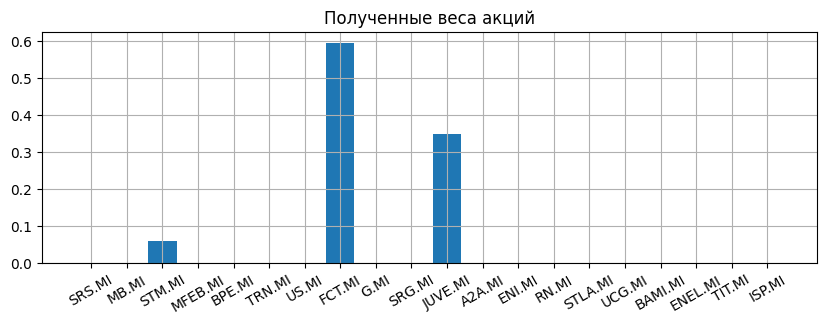

In [9]:
def plot_weights_histogram(weights, ticker_list, name, size = (10,3)):
    plt.figure(figsize=(6,12))
    x = ticker_list
    y = weights
    fig, ax = plt.subplots(figsize=size) 
    plt.title(name)
    plt.grid()
    ax.bar(x, y)
    plt.xticks(rotation=30)
    plt.show()
    
plot_weights_histogram(X, ticker_list_20, name="Полученные веса акций")

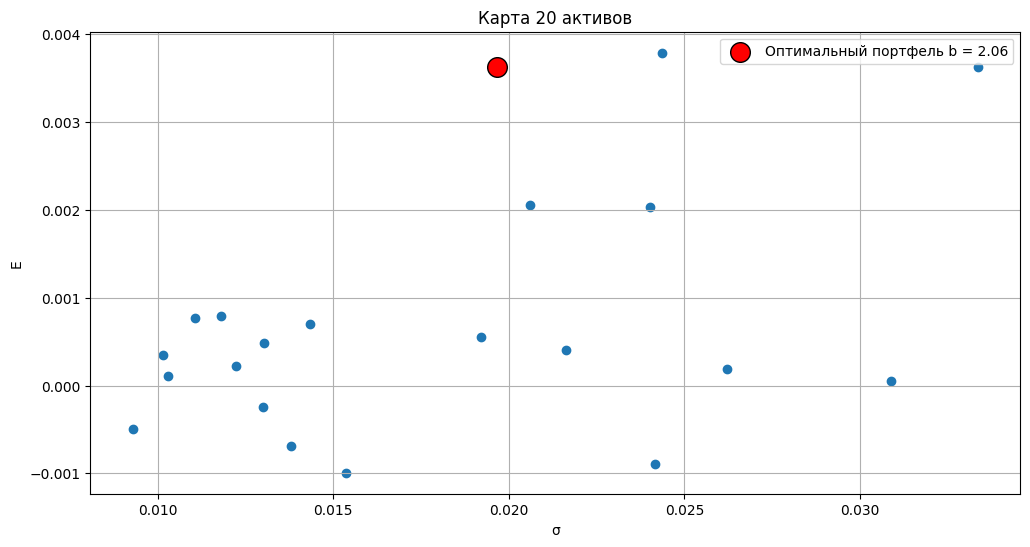

In [10]:
plt.figure(figsize=(12, 6))
plt.xlabel('σ')
plt.ylabel('E')
plt.grid(True)
plt.title("Карта 20 активов")
plt.scatter(vars, E)
plt.scatter(risk_portfolio(X, cov_matrix), np.dot(E,X), c='red',s=200, edgecolors='black', label='Оптимальный портфель b = %.2f' % b)
plt.legend()

plt.show()

### 2. Оценка неопределенности оптимального портфеля в модели Марковица с заданным отношением к риску. 


**2.1 Задайте число наблюдений T=30. С помощью генератора многомерного нормального распределения создайте выборку размера Т из нормального распределения с вектором математических ожиданий  E=(E1, E2, …, EN) и матрицей ковариаций (σi,j).** 

In [11]:
T = 30
r_matrix_gen = np.random.multivariate_normal(E, cov_matrix, T)
r_matrix_gen.shape

(30, 20)

**2.2. По построенной выборке сделайте оценку $E^{est}$ вектора математических ожиданий и оценку $ \sigma ^{est}$ матрицы ковариаций.**

In [12]:
E_est = np.mean(r_matrix_gen, axis=0)
cov_matrix_est = np.cov(r_matrix_gen.T)
E_est.shape, cov_matrix_est.shape

((20,), (20, 20))

In [13]:
print('Истинный вектор средних:')
print(np.around(E, 3))
print()
print('Оценки вектора средних:')
print(np.around(E_est, 3))

Истинный вектор средних:
[ 0.001  0.001  0.002 -0.001 -0.001  0.    -0.     0.004  0.     0.
  0.004  0.001 -0.     0.     0.002  0.     0.     0.001 -0.001  0.   ]

Оценки вектора средних:
[ 0.005 -0.001  0.002 -0.004 -0.003 -0.001 -0.002  0.006 -0.002  0.001
  0.007 -0.001  0.001 -0.002 -0.002  0.001 -0.003 -0.     0.002 -0.001]


**2.3 Используя эти оценки решите задачу оптимизации**

- $-E^{est}(x)+ b\sigma^{est}(x) \rightarrow min,$  
- $x_1+x_2+\cdots+x_N =1$ 
- $x_i \ge 0$

Здесь $E^{est}(x)= E^{est}_1 x_1+E^{est}_2 x_2+\cdots+E^{est}_N x_N$ , $ \sigma^{est} (x)= \sum \sum σ^{est}_{ij} x_ix_j$

(т.е. найдите выборочный оптимальный портфель с отношением к риску, равным b). Найдите и зафиксируйте веса портфеля и значение целевой функции.

In [14]:
X_est = optimize_portfolio(E_est, cov_matrix_est, b, bounds=((0, 1),))

**2.4 Сравните два портфеля: истинный (п.1) и выборочный (п.2.3).**

Оцените относительную ошибку в определении весов портфеля в норме Manhattan (L1 норма Минковского). Сделайте выводы. Сделайте сравнение в системе координат (σ, E).

<Figure size 600x1200 with 0 Axes>

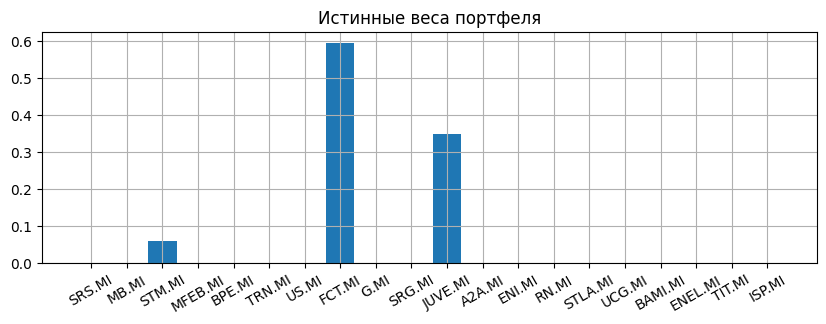

<Figure size 600x1200 with 0 Axes>

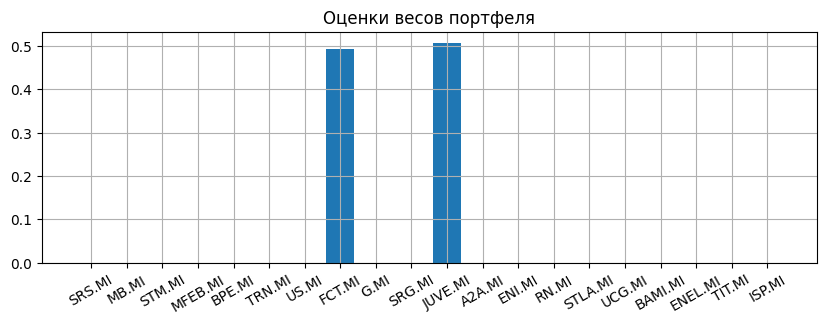

In [15]:
plot_weights_histogram(X, ticker_list_20, "Истинные веса портфеля")
plot_weights_histogram(X_est, ticker_list_20, "Оценки весов портфеля")

In [16]:
print('L1 норма вектора X - Xest:', np.around(np.linalg.norm(X - X_est, ord=1), 3))

L1 норма вектора X - Xest: 0.321


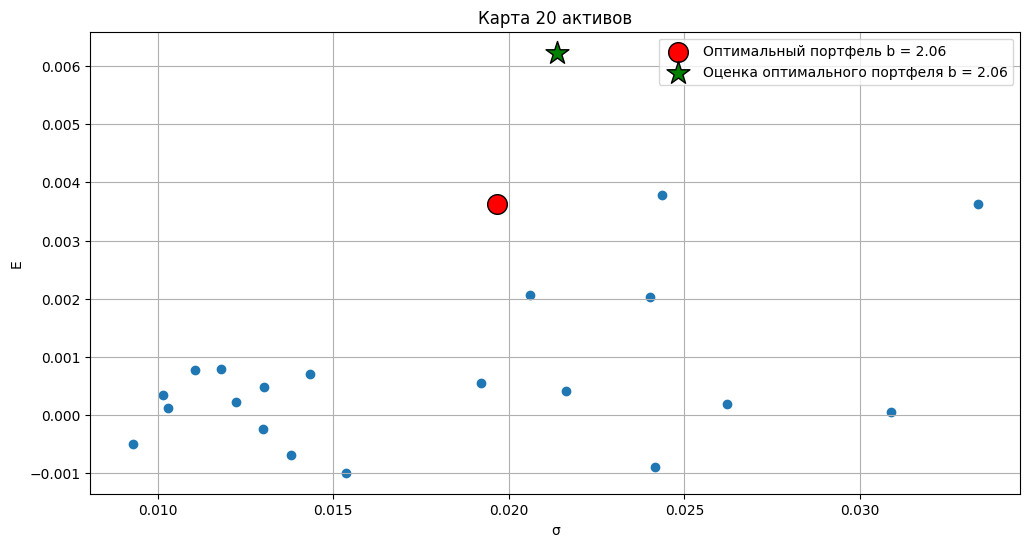

In [17]:
plt.figure(figsize=(12, 6))
plt.xlabel('σ')
plt.ylabel('E')
plt.grid(True)
plt.title("Карта 20 активов")
plt.scatter(vars, E)
plt.scatter(risk_portfolio(X, cov_matrix), np.dot(E,X), c='red',s=200, edgecolors='black', 
            label='Оптимальный портфель b = %.2f' % b)
plt.scatter(risk_portfolio(X_est, cov_matrix_est), np.dot(E_est,X_est), marker='*', c='green',s=300, edgecolors='black', 
            label='Оценка оптимального портфеля b = %.2f' % b)
plt.legend()

plt.show()

**Исходя из значений весов портфеля и их оценок, L1-нормы этих векторов, а также сравнения портфелей по карте $E$ от $\sigma$ можно заметить, что разница относительно низкая. Оценка оптимального портфеля с параметром $b$ имеет более высокую доходность и низкий риск.**

### 2.5. Повторите эксперимент S=40 раз и оцените среднюю относительную ошибку по S повторениям эксперимента.

Сделайте выводы.  

Сделайте сравнение в системе координат (σ, E). 

In [18]:
S = 40 

experiments = []

for i in range(S):
    experiment = {}
    experiment['i'] = i
    experiment['r_matrix_gen'] = np.random.multivariate_normal(E, cov_matrix, T)
    experiment['E_est'] = np.mean(experiment['r_matrix_gen'], axis=0)
    experiment['cov_matrix_est'] = np.cov(experiment['r_matrix_gen'].T)
    experiment['X_est'] =  optimize_portfolio( experiment['E_est'], experiment['cov_matrix_est'], 
                                              b, bounds=((0, 1),))
    experiment['L1-norm'] = np.linalg.norm(X - experiment['X_est'], ord=1)
    experiments.append(experiment)

In [19]:
l1_norms = [experiment['L1-norm'] for experiment in experiments]
l1_norms_mean  = np.mean(l1_norms)
l1_norms_std  = np.std(l1_norms)
print(f'Средняя L1-норма по 40 экспериментам: {l1_norms_mean:.3f}')
print(f'Примерный 95% доверительный интервал: [{l1_norms_mean - 2*l1_norms_std:.3f}, {l1_norms_mean + 2*l1_norms_std:.3f}]')

Средняя L1-норма по 40 экспериментам: 1.364
Примерный 95% доверительный интервал: [0.427, 2.302]


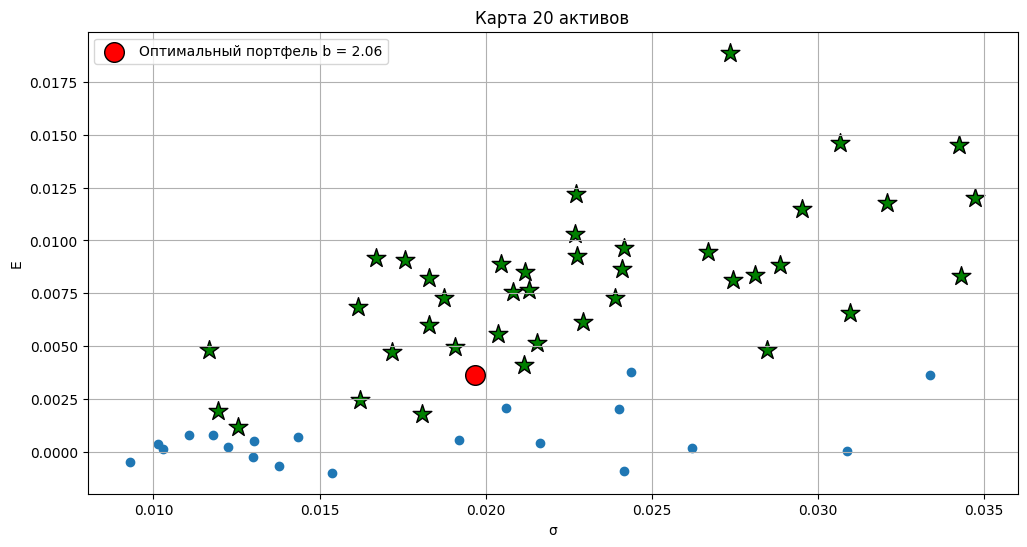

In [20]:
plt.figure(figsize=(12, 6))
plt.xlabel('σ')
plt.ylabel('E')
plt.grid(True)
plt.title("Карта 20 активов")
plt.scatter(vars, E)
plt.scatter(risk_portfolio(X, cov_matrix), np.dot(E,X), c='red',s=200, edgecolors='black', 
            label='Оптимальный портфель b = 2.06')
for experiment in experiments:
    plt.scatter(risk_portfolio(experiment['X_est'], experiment['cov_matrix_est']),np.dot(experiment['E_est'], experiment['X_est']), 
                marker='*', c='green',s=200, edgecolors='black')
plt.legend()
plt.show()

**На графике можно заметить, что большинство портфелей сильно отличаются от истинного, хотя несколько из них относительно близки к истиному на карте активов.**

### 2.6  Предположите, что нам известны точные значения математических ожиданий E=(E1, E2, …, EN).

Повторите пп. 2.2-2.5. используя оценку только матрицы ковариаций (т.е. решайте задачу оптимизации 

- $-E^{est}(x)+ b\sigma^{est}(x) \rightarrow min,$  
- $x_1+x_2+\cdots+x_N =1$ 
- $x_i \ge 0$

Здесь $E^{est}(x)= E^{est}_1 x_1+E^{est}_2 x_2+\cdots+E^{est}_N x_N$ , $ \sigma^{est} (x)= \sum \sum σ^{est}_{ij} x_ix_j$


Сравните точность этих портфелей и портфелей п.2.5(2.3)

In [21]:
experiments_with_true_mean = []

for i in range(S):
    experiment = {}
    experiment['i'] = i
    experiment['r_matrix_gen'] = np.random.multivariate_normal(E, cov_matrix, T)
    experiment['E_est'] = np.mean(experiment['r_matrix_gen'], axis=0)
    experiment['cov_matrix_est'] = np.cov(experiment['r_matrix_gen'].T)
    experiment['X_est'] =  optimize_portfolio(E, experiment['cov_matrix_est'], 
                                              b, bounds=((0, 1),))
    experiment['L1-norm'] = np.linalg.norm(X - experiment['X_est'], ord=1)
    experiments_with_true_mean.append(experiment)

In [22]:
l1_norms = [experiment['L1-norm'] for experiment in experiments_with_true_mean]
l1_norms_mean  = np.mean(l1_norms)
l1_norms_std  = np.std(l1_norms)
print(f'Средняя L1-норма по 40 экспериментам: {l1_norms_mean:.3f}')
print(f'Примерный 95% доверительный интервал: [{l1_norms_mean - 2*l1_norms_std:.3f}, {l1_norms_mean + 2*l1_norms_std:.3f}]')

Средняя L1-норма по 40 экспериментам: 0.243
Примерный 95% доверительный интервал: [-0.075, 0.561]


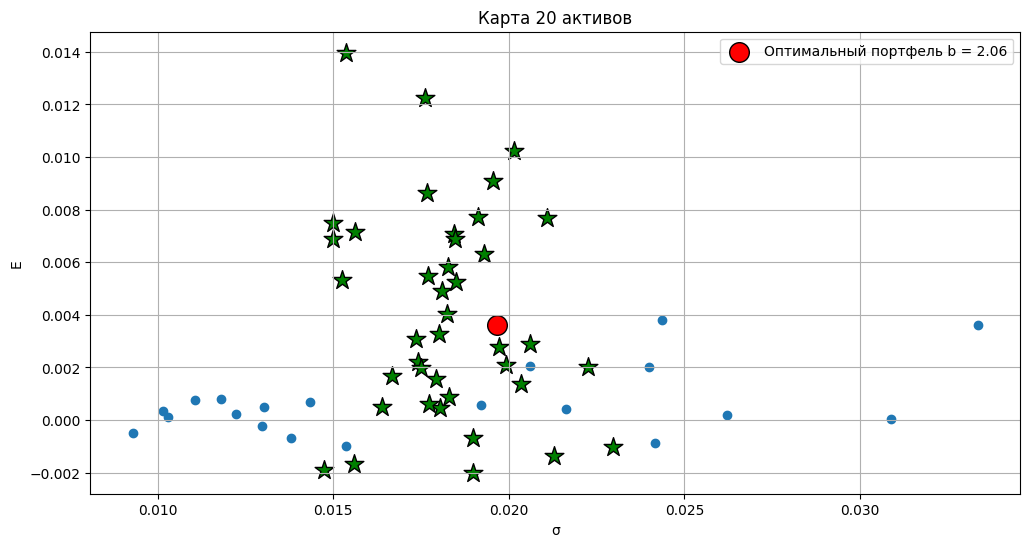

In [23]:
plt.figure(figsize=(12, 6))
plt.xlabel('σ')
plt.ylabel('E')
plt.grid(True)
plt.title("Карта 20 активов")
plt.scatter(vars, E)
plt.scatter(risk_portfolio(X, cov_matrix), np.dot(E,X), c='red',s=200, edgecolors='black', 
            label='Оптимальный портфель b = %.2f' % b)
for experiment in experiments_with_true_mean:
    plt.scatter(risk_portfolio(experiment['X_est'], experiment['cov_matrix_est']),np.dot(experiment['E_est'], experiment['X_est']), 
                marker='*', c='green',s=200, edgecolors='black')
plt.legend()
plt.show()

**Исходя из результатов экспериментов с истинным вектором средних можно заметить, что оценки весов сильно улучшились и стали ближе к истинным, такой же вывод можно сделать и по по карте активов $E$ от $\sigma$, где сгенерированные портфели стали располагаться ближе.**

### 3. Оценка неопределенности оптимального CVaR портфеля 

**3.1 Уровень значимости β выбран 0,95. Число наблюдений T.**

Используя сгенерированные наблюдения из п.2.1 решите задачу ЛП для определения оптимального CVaR β портфеля.  Найдите и зафиксируйте веса портфеля и значение целевой функции CVaR.  

In [24]:
def cvar_fun(UXalpha, T, beta):
    return UXalpha[-1] + 1 / (T * (1 - beta)) * np.sum(UXalpha[:T])
    
def cvar_optimize_portfolio(r_matrix, beta, cvar_fun=cvar_fun,):
    alpha  = 0 
    N = r_matrix.shape[1]
    X = np.ones(N)/ N 
   
    T = r_matrix.shape[0] 
    U = np.dot(r_matrix,  X) - alpha
    
    UXalpha = np.zeros(T+N+1)
    UXalpha[:T] = U
    UXalpha[T:N+T]= X
    UXalpha[-1] = alpha
    
    bounds_U = ((0, 10**10),) * T
    bounds_X = ((0, 1.1),) * N
    bounds_alpha = ((-100000, 100000),)
    bounds = bounds_U + bounds_X + bounds_alpha
    
    
    constraints = []
    constraints.append({'type': 'eq', 'fun': lambda X: sum(X[T:N+T]) -1})
    def u_x_con(UXalpha, r_matrix, i):
        return np.dot(r_matrix[i], UXalpha[T:N+T]) + UXalpha[-1] - UXalpha[i],
    for i in range(T):
        constraints.append({'type': 'ineq', 
                            'fun': u_x_con,
                            'args': (r_matrix, i)})

    
    return minimize(cvar_fun, UXalpha, args=(T, beta), method='SLSQP',
                    constraints=constraints, bounds=bounds).x

In [25]:
result = cvar_optimize_portfolio(r_matrix_gen, beta)
T = 30
N = 20
UXalpha = result
cvar_X_est = UXalpha[T:N+T]
alpha_est  = UXalpha[-1]

print('Alpha CVAR портфеля:' ,round(alpha_est, 6))
print('VAR CVAR портфеля на уровне 0.95:' ,round(np.quantile(-np.dot(r_matrix_gen, cvar_X_est), 0.95), 6))

Alpha CVAR портфеля: 0.004134
VAR CVAR портфеля на уровне 0.95: 0.004134


<Figure size 600x1200 with 0 Axes>

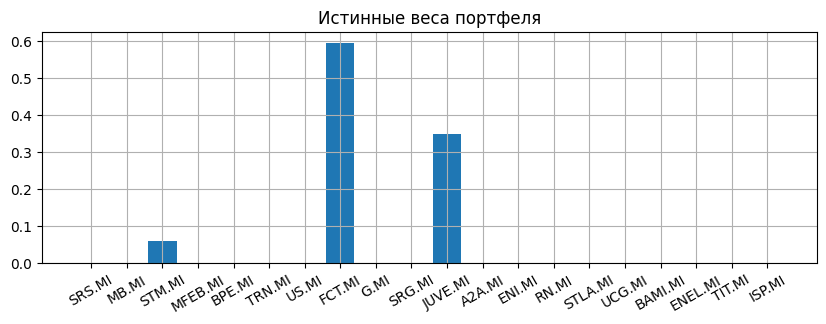

<Figure size 600x1200 with 0 Axes>

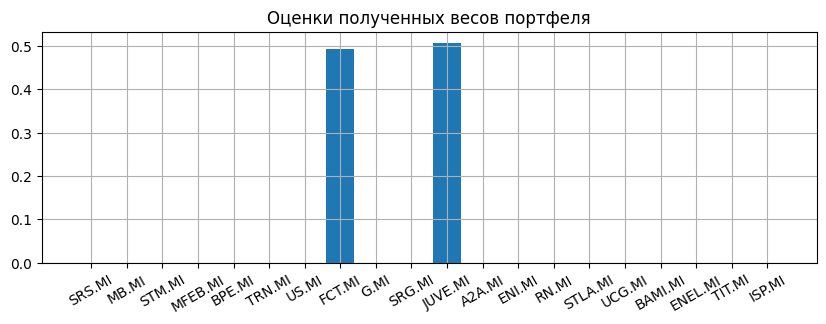

<Figure size 600x1200 with 0 Axes>

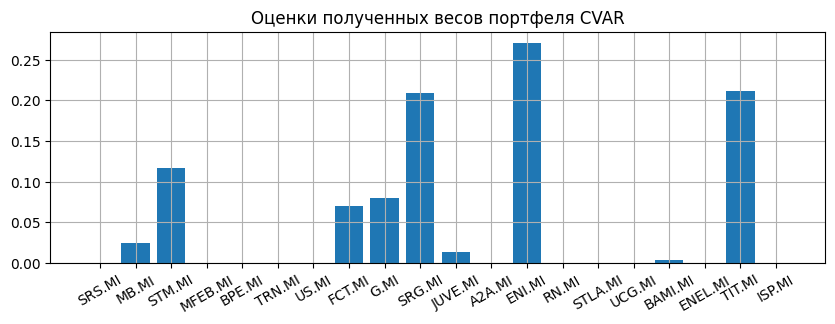

In [26]:
plot_weights_histogram(X, ticker_list_20, "Истинные веса портфеля")
plot_weights_histogram(X_est, ticker_list_20, "Оценки полученных весов портфеля")
plot_weights_histogram(cvar_X_est, ticker_list_20, "Оценки полученных весов портфеля CVAR")

**3.2 Сравните два портфеля: истинный (п.1) и найденный в п.3.1.**  
    
Оцените относительную ошибку в определении весов портфеля в норме Manhattan (L1 норма Минковского). Сравните с ошибкой портфеля из п. 2.3

In [27]:
print('L1 норма вектора X_est в 2.3 :       ', np.around(np.linalg.norm(X - X_est, ord=1), 3))
print('L1 норма вектора для CVAR cvar_X_est:', np.around(np.linalg.norm(X - cvar_X_est, ord=1), 3))

L1 норма вектора X_est в 2.3 :        0.321
L1 норма вектора для CVAR cvar_X_est: 1.717


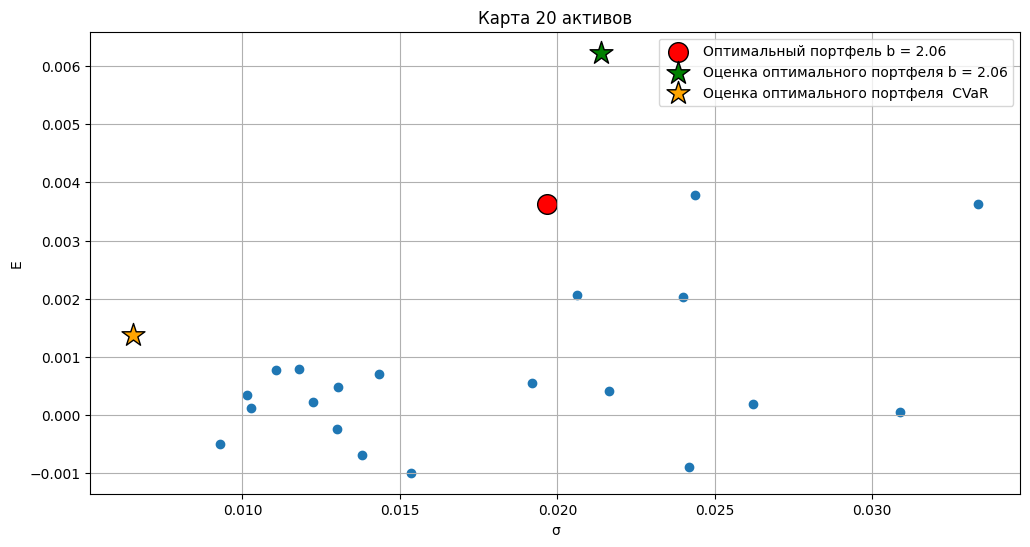

In [33]:
plt.figure(figsize=(12, 6))
plt.xlabel('σ')
plt.ylabel('E')
plt.grid(True)
plt.title("Карта 20 активов")
plt.scatter(vars, E)
plt.scatter(risk_portfolio(X, cov_matrix), np.dot(E,X), c='red',s=200, edgecolors='black', 
            label='Оптимальный портфель b = %.2f' % b)
plt.scatter(risk_portfolio(X_est, cov_matrix_est),
            np.dot(E_est, X_est), c='green', marker='*', s=300, 
            edgecolors='black',label=f'Оценка оптимального портфеля b = {b:.2f}')

plt.scatter(risk_portfolio(cvar_X_est, cov_matrix_est),
            np.dot(E_est, cvar_X_est), c='orange',marker='*',s=300, 
            edgecolors='black', label='Оценка оптимального портфеля  CVaR')
plt.legend()
plt.show()

**Исходя из полученных L1 норм, можно сделать вывод, что этот портфель находится дальше от истинного, так же это видно на карте активов.**

### 3.3. Повторите эксперимент S раз и оцените среднюю относительную ошибку по S повторениям эксперимента. 

Сделайте выводы.  Сравните с ошибкой из п. 2.5 

In [29]:
S = 40 

cvar_experiments = []

for i in range(S):
    cvar_experiment = {}
    cvar_experiment['i'] = i
    cvar_experiment['r_matrix_gen'] = np.random.multivariate_normal(E, cov_matrix, T)
    cvar_experiment['mean_vec_est'] = np.mean(cvar_experiment['r_matrix_gen'], axis=0)
    cvar_experiment['cov_matrix_est'] = np.cov(cvar_experiment['r_matrix_gen'].T)
    cvar_experiment['cvar_X_est'] =  cvar_optimize_portfolio(cvar_experiment['r_matrix_gen'], beta)
    cvar_experiment['L1-norm'] = np.linalg.norm(X - cvar_experiment['cvar_X_est'][T:N+T], ord=1)
    cvar_experiments.append(cvar_experiment)

In [30]:
l1_norms = [experiment['L1-norm'] for experiment in experiments]
l1_norms_mean  = np.mean(l1_norms)
l1_norms_std  = np.std(l1_norms)
print(f'Средняя L1-норма из пункта 2.5 по 40 экспериментам: {l1_norms_mean:.3f}')
print(f'Примерный 95 прц. доверительный интервал: [{l1_norms_mean - 2*l1_norms_std:.3f}, {l1_norms_mean + 2*l1_norms_std:.3f}]')

Средняя L1-норма из пункта 2.5 по 40 экспериментам: 1.364
Примерный 95 прц. доверительный интервал: [0.427, 2.302]


In [31]:
l1_norms = [cvar_experiment['L1-norm'] for cvar_experiment in cvar_experiments]
l1_norms_mean  = np.mean(l1_norms)
l1_norms_std  = np.std(l1_norms)
print(f'Средняя L1-норма CVAR по 40 экспериментам: {l1_norms_mean:.3f}')
print(f'Примерный 95% доверительный интервал: [{l1_norms_mean - 2*l1_norms_std:.3f}, {l1_norms_mean + 2*l1_norms_std:.3f}]')

Средняя L1-норма CVAR по 40 экспериментам: 1.784
Примерный 95% доверительный интервал: [1.465, 2.103]


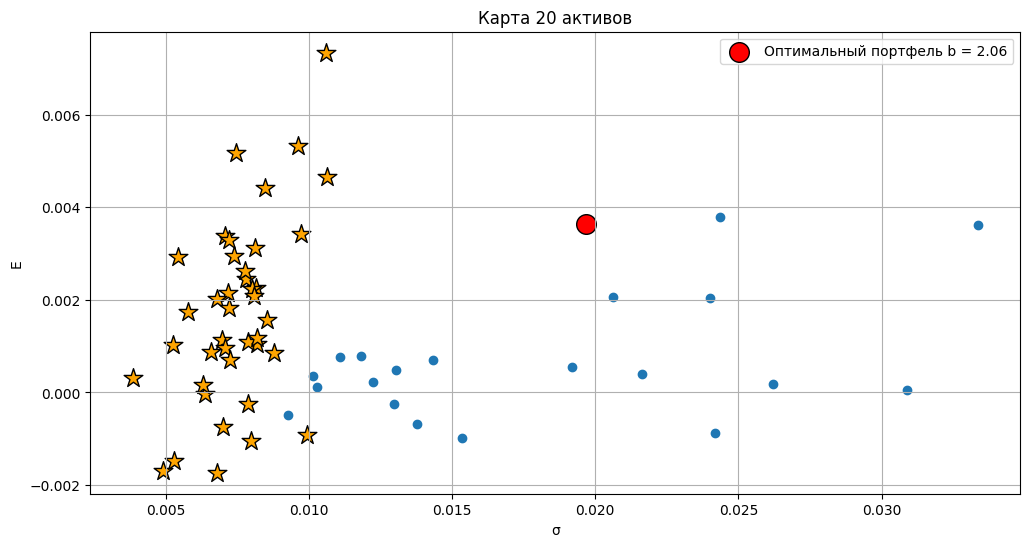

In [32]:
plt.figure(figsize=(12, 6))
plt.xlabel('σ')
plt.ylabel('E')
plt.grid(True)
plt.title("Карта 20 активов")
plt.scatter(vars, E)
plt.scatter(risk_portfolio(X, cov_matrix), np.dot(E,X), c='red',s=200, edgecolors='black', 
            label='Оптимальный портфель b = %.2f' % b)
for experiment in cvar_experiments:
    plt.scatter(risk_portfolio(experiment['cvar_X_est'][T:N+T], experiment['cov_matrix_est']),
                np.dot(experiment['mean_vec_est'], experiment['cvar_X_est'][T:N+T]), 
                c='orange', marker='*', s=200, edgecolors='black')
plt.legend()
plt.show()

**Исходя из результатов экспериментов  для CVAR портфелей можно заметить, что оценки истинного портфеля хуже, чем в пункте 2.5, также на карте активов можно заметить что ни находятся намного дальше и смещены в сторону более низких доходностей и рисков.**